In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


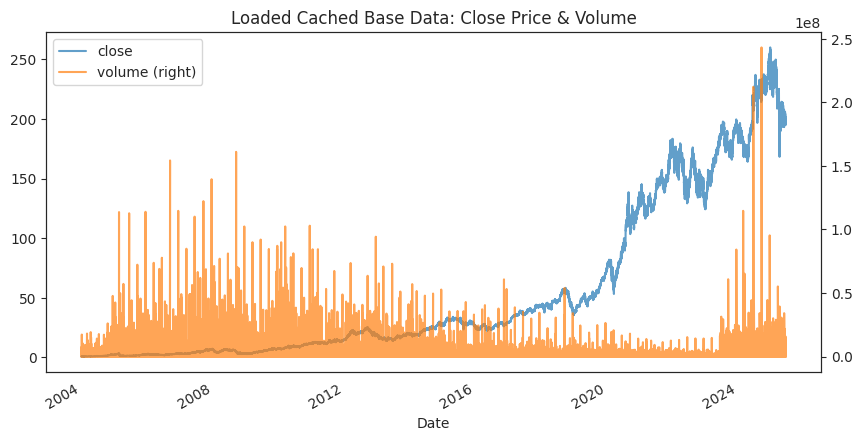

,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [2]:
ticker = params.ticker
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal',
                                         col_action='signal_action',
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal',
        col_signal2=False,
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=params.buy_threshold_tick,
        performance_stats=perf_day
    )

    print(f"\n* Performance for {day_dt} *")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day()
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)
      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
          – compute & print the full‐period summary
          – plot full‐period performance (now on df_all)
          – isolate & compute the test‐period summary
          – plot test‐period performance (on df_test)
          – save every day’s signals to params.sign_csv
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open", "high", "low", "close",
        "volume", "bid", "ask",
        "StrategyEarning", "EarningDiff",
        "signal", "signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
        df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
          .index
          .normalize()
          .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        res = process_single_day(str(day.date()))
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline(
        df=df,
        col_signal='signal',
        col_action='signal_action'
    )

    # Build combined DataFrame & performance list (with zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # Compute test‐period metrics & plot on df_all subset
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all



Month mode: processing 2015-05

=== Processing trading day 2015-05-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-01 00:00:00 *
Buy & Hold Return ($): 0.628
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-04 00:00:00 *
Buy & Hold Return ($): -0.255
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-05 00:00:00 *
Buy & Hold Return ($): -0.587
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-06 00:00:00 *
Buy & Hold Return ($): -0.381
Strategy Return ($): 0.04
Trades Returns ($): [0.04]

=== Processing trading day 2015-05-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-07 00:00:00 *
Buy & Hold Return ($): 0.13
Strategy Return ($): 0.084
Trades Returns ($): [0.072, 0.011]

=== Processing trading day 2015-05-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-08 00:00:00 *
Buy & Hold Return ($): 0.291
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-11 00:00:00 *
Buy & Hold Return ($): -0.239
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-12 00:00:00 *
Buy & Hold Return ($): 0.069
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-13 00:00:00 *
Buy & Hold Return ($): -0.056
Strategy Return ($): 0.175
Trades Returns ($): [0.175]

=== Processing trading day 2015-05-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-14 00:00:00 *
Buy & Hold Return ($): 0.341
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-15 00:00:00 *
Buy & Hold Return ($): -0.124
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-18 00:00:00 *
Buy & Hold Return ($): 0.348
Strategy Return ($): 0.347
Trades Returns ($): [0.128, 0.219]

=== Processing trading day 2015-05-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-19 00:00:00 *
Buy & Hold Return ($): -0.077
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-20 00:00:00 *
Buy & Hold Return ($): -0.015
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-21 00:00:00 *
Buy & Hold Return ($): 0.355
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-22 00:00:00 *
Buy & Hold Return ($): 0.273
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-26 00:00:00 *
Buy & Hold Return ($): -0.784
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-27 00:00:00 *
Buy & Hold Return ($): 0.416
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-28 00:00:00 *
Buy & Hold Return ($): 0.035
Strategy Return ($): 0.0
Trades Returns ($): []

=== Processing trading day 2015-05-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2015-05-29 00:00:00 *
Buy & Hold Return ($): -0.255
Strategy Return ($): 0.0
Trades Returns ($): []

Overall Summary (2015-05-01 = 31.5895 → 2015-05-29 = 32.6052)

One-time buy&hold gain: 1.016
Buy & Hold – each day ($): 0.113
Strategy Return ($): 0.646
Trades Count: 6
Strategy return per trade: 0.108
Num. trading days: 20
Strategy return per trading day: 0.032


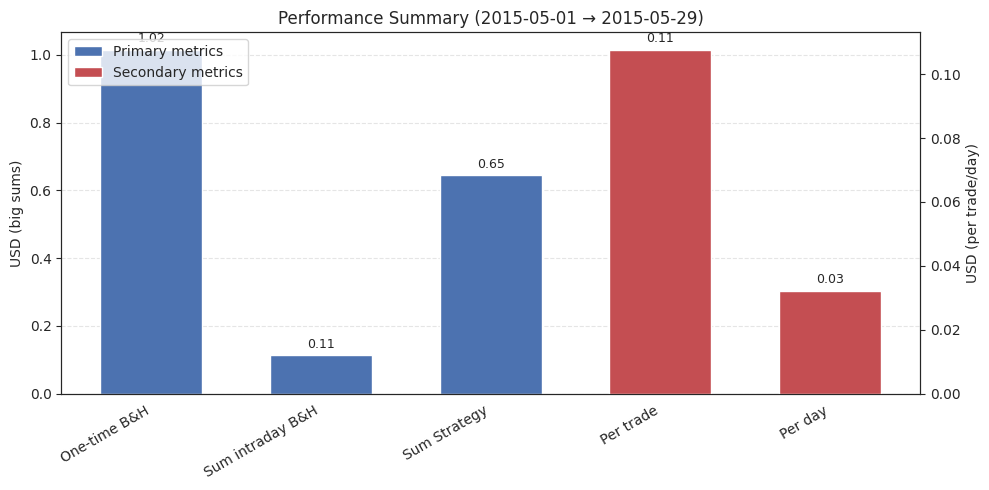


Full‐run mode
• Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

Full‐period performance:

Overall Summary (2004-01-02 = 0.7727 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 195.708
Buy & Hold – each day ($): -121.224
Strategy Return ($): 1264.448
Trades Count: 4555
Strategy return per trade: 0.278
Num. trading days: 5400
Strategy return per trading day: 0.234


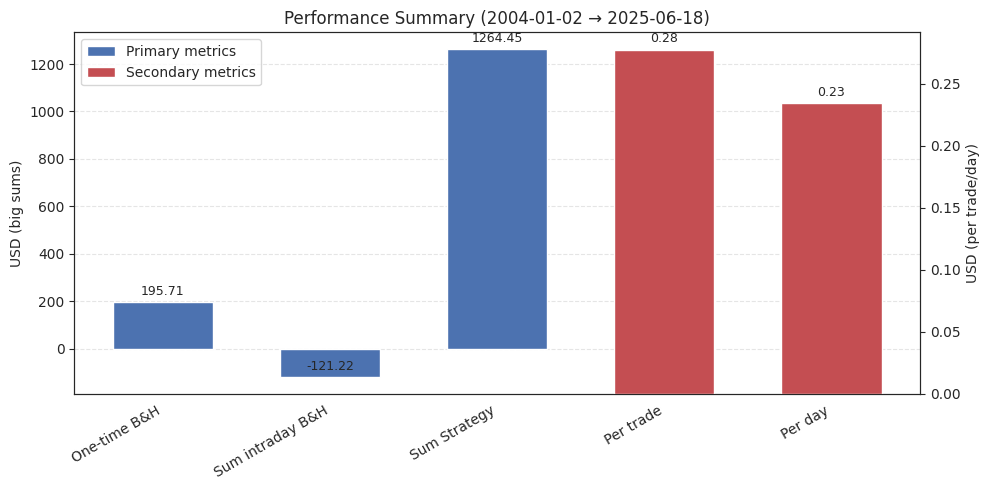


Test‐period performance:

Overall Summary (2022-03-28 = 172.7518 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 23.729
Buy & Hold – each day ($): -54.954
Strategy Return ($): 644.706
Trades Count: 563
Strategy return per trade: 1.145
Num. trading days: 810
Strategy return per trading day: 0.796


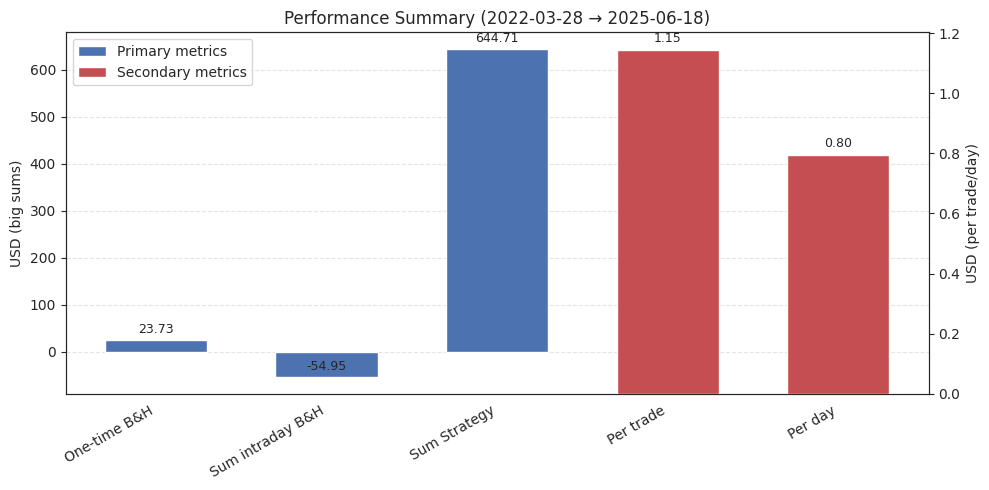


• Saving signals CSV …
Saved to dfs_training/AAPL_2_sign.csv


,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal,signal_action
2004-01-02 09:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.0,0.000,0.054117,0
2004-01-02 09:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.0,0.000,0.054702,0
2004-01-02 09:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.0,0.000,0.055294,0
2004-01-02 09:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.0,0.000,0.055891,0
2004-01-02 09:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764057,0.764514,0.0,0.000,0.056496,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.756000,196.874000,0.0,-0.777,0.000000,0
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.616000,196.734000,0.0,-0.637,0.000000,0
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.611000,196.729000,0.0,-0.632,0.000000,0
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.181100,196.298900,0.0,-0.202,0.000000,0


In [5]:
df_fin = saveDF_checkDAY(
                        df=df,
                        )

df_fin

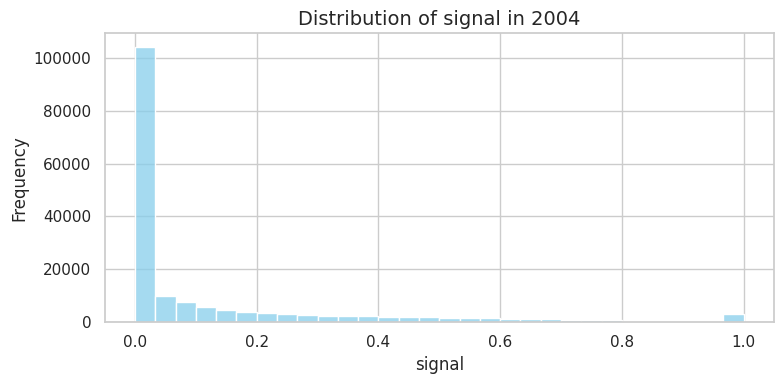

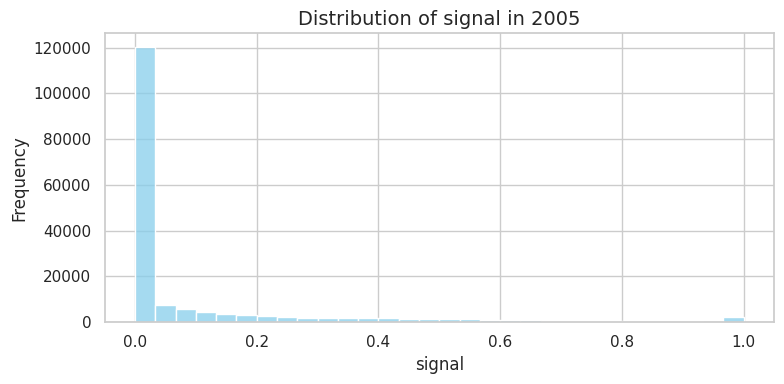

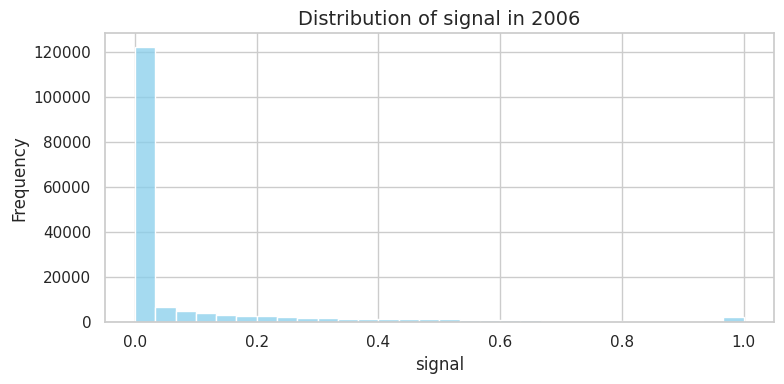

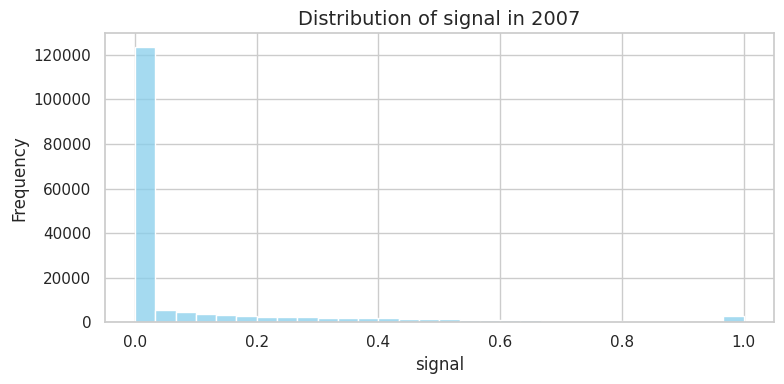

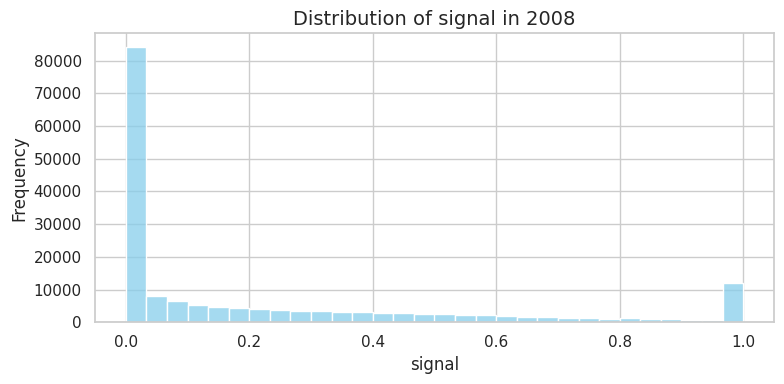

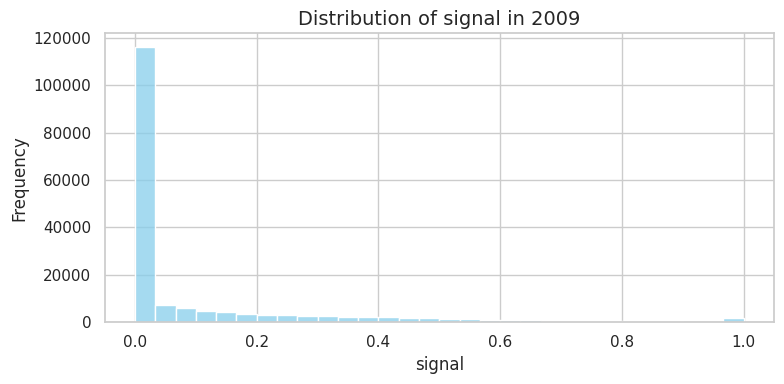

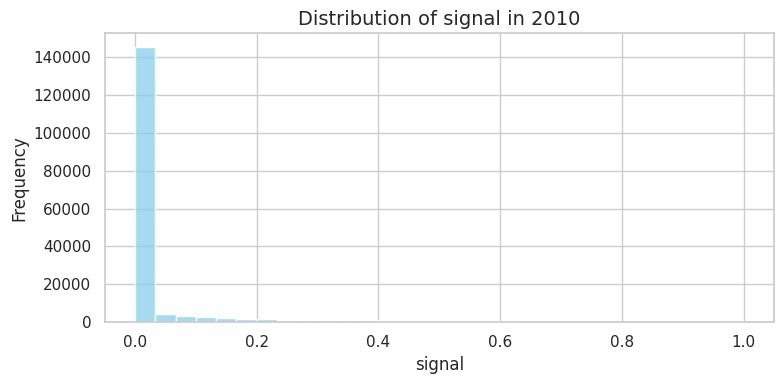

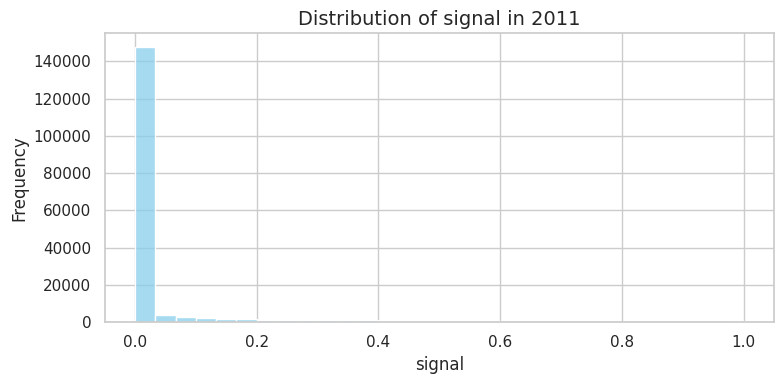

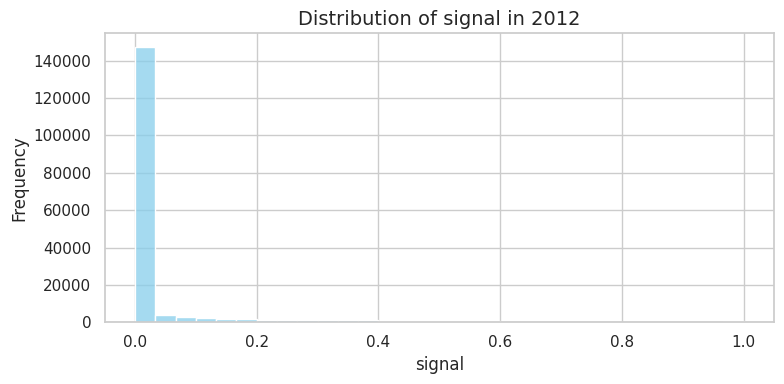

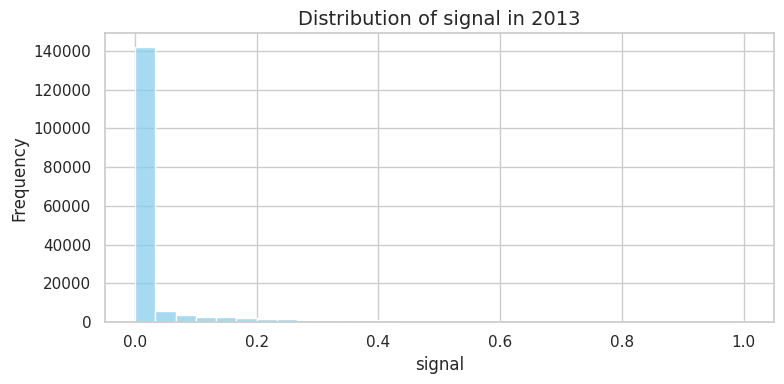

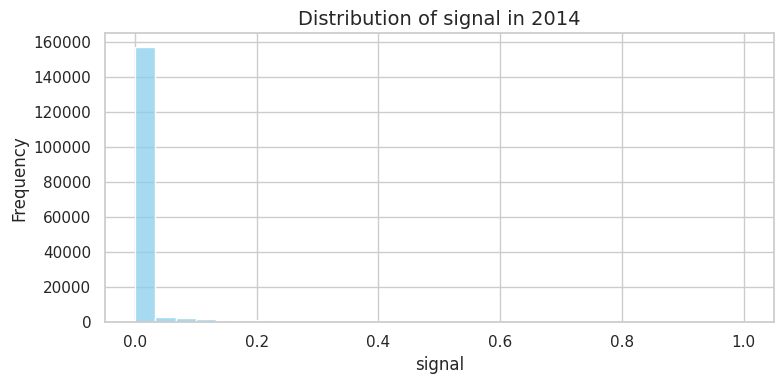

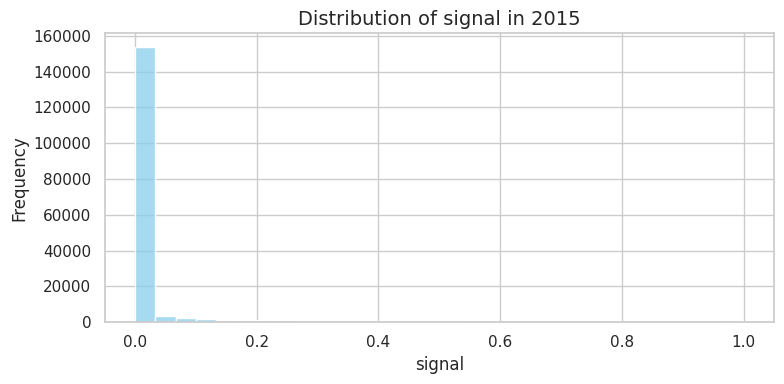

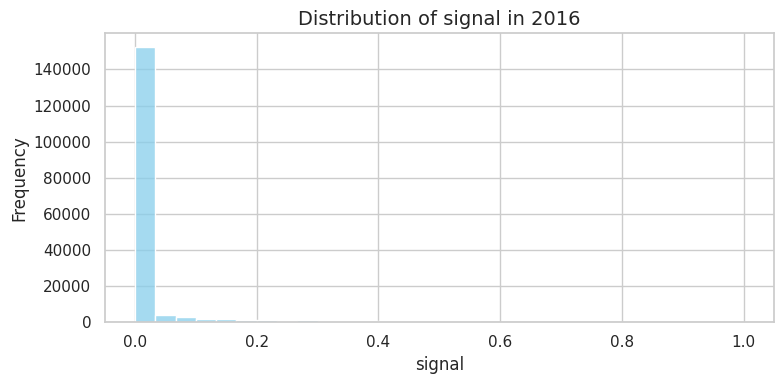

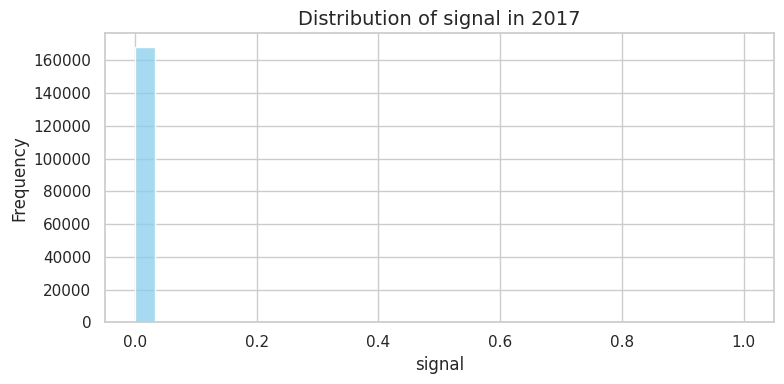

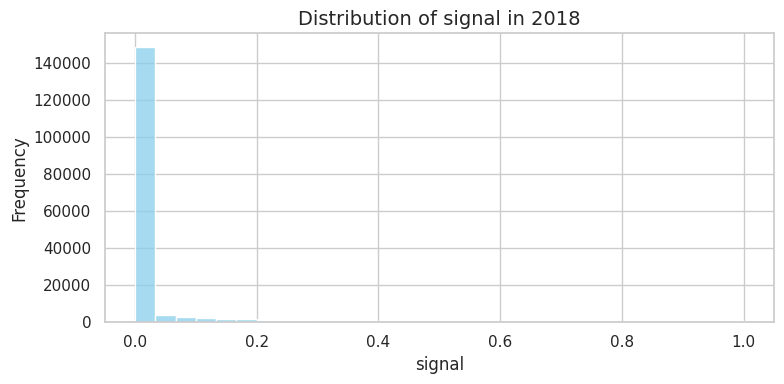

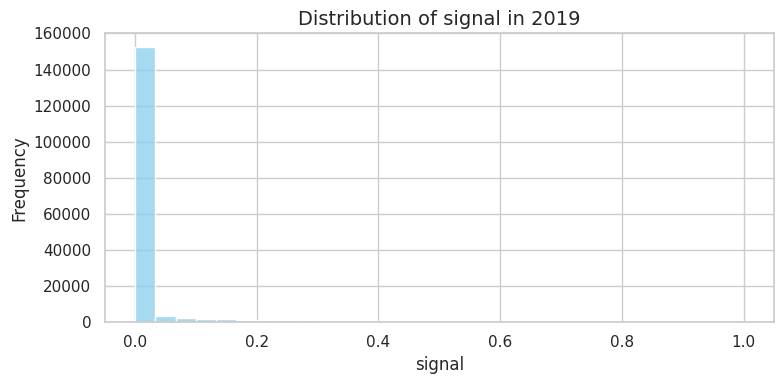

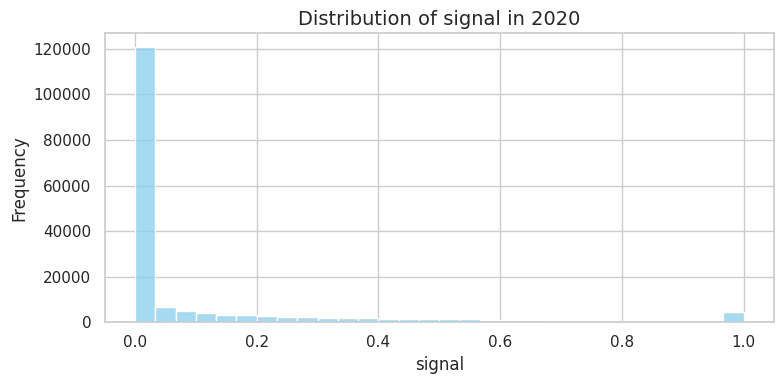

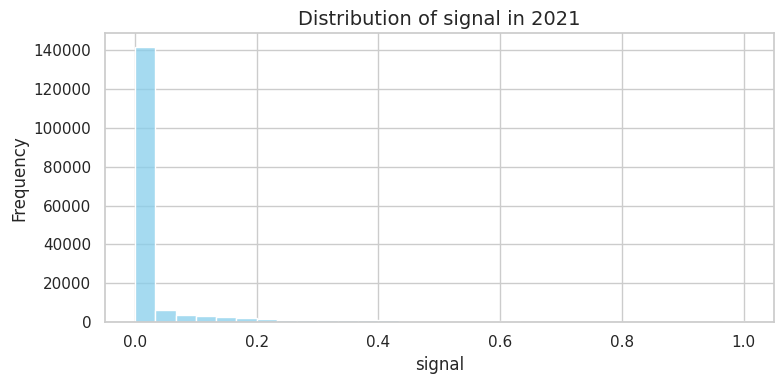

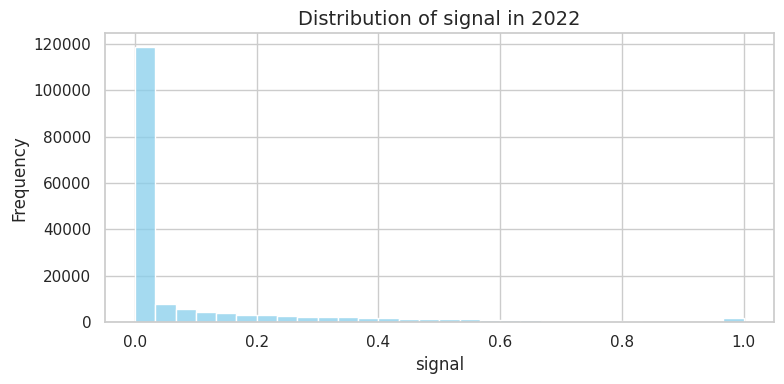

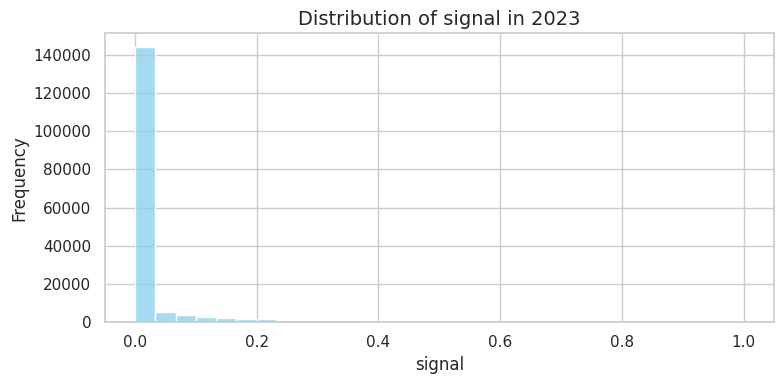

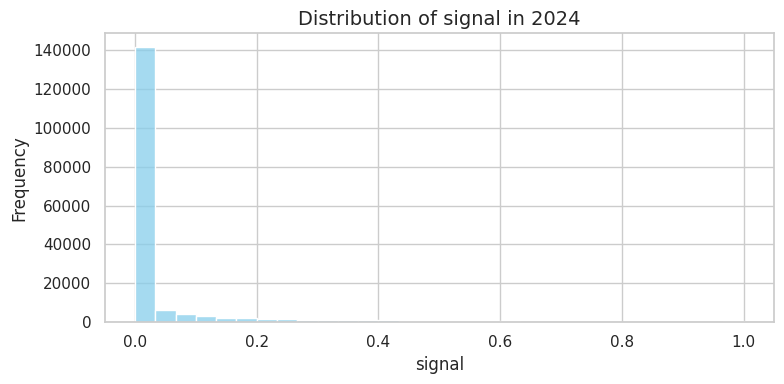

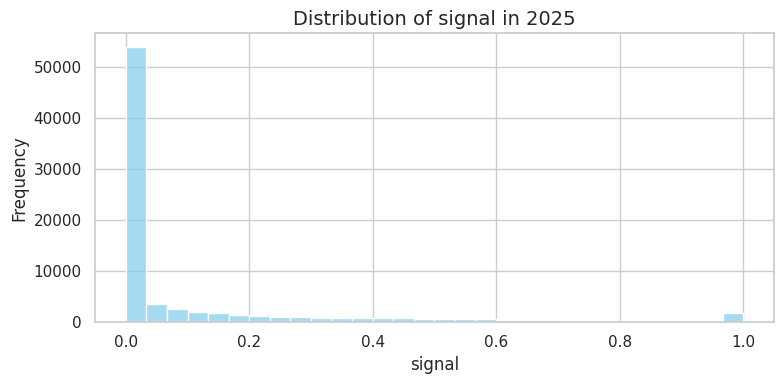

,signal_min,signal_max,signal_mean,signal_median,close_return
2004-01,0.0,1.0,0.138939,0.000902,0.170916
2004-02,0.0,1.0,0.097410,0.000000,0.105893
2004-03,0.0,1.0,0.166806,0.000000,0.196335
2004-04,0.0,1.0,0.115471,0.000000,0.156863
2004-05,0.0,1.0,0.141988,0.000000,0.127743
...,...,...,...,...,...
2025-02,0.0,1.0,0.095372,0.000000,0.105627
2025-03,0.0,1.0,0.108100,0.000000,0.168574
2025-04,0.0,1.0,0.255156,0.062450,0.338585
2025-05,0.0,1.0,0.079546,0.000000,0.109857


In [6]:
# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
